In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.utils import resample
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [2]:
train = pd.read_pickle("train_dataset3.pkl")
test = pd.read_pickle("test_dataset3.pkl")

# K-Means

In [4]:
# Dummify the 'ServiceType' Feature 

dummy = pd.get_dummies(test['ServiceType'], drop_first=True)

test1 = pd.concat([test, dummy], axis=1).drop('ServiceType', axis=1)

In [5]:
test1 = test1.drop(['Provider'], axis=1)

In [6]:
# Standardize the test dataset 

scaler = StandardScaler()
test_std = scaler.fit_transform(test1)

In [7]:
kmeans = KMeans()
kmeans.set_params(n_clusters=2)

kmeans.fit(test_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [8]:
KMeansClass = kmeans.predict(test_std)

In [9]:
# Make DataFrame of cluster labels 

KClass = pd.DataFrame(KMeansClass)

In [10]:
KClass[0].value_counts()

0    1303
1      50
Name: 0, dtype: int64

In [11]:
KClass = KClass.rename(columns={0:'KClass'})

# Elbow Method to Assess Optimal K

In [13]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(test_std)
    distortions.append(kmeanModel.inertia_)

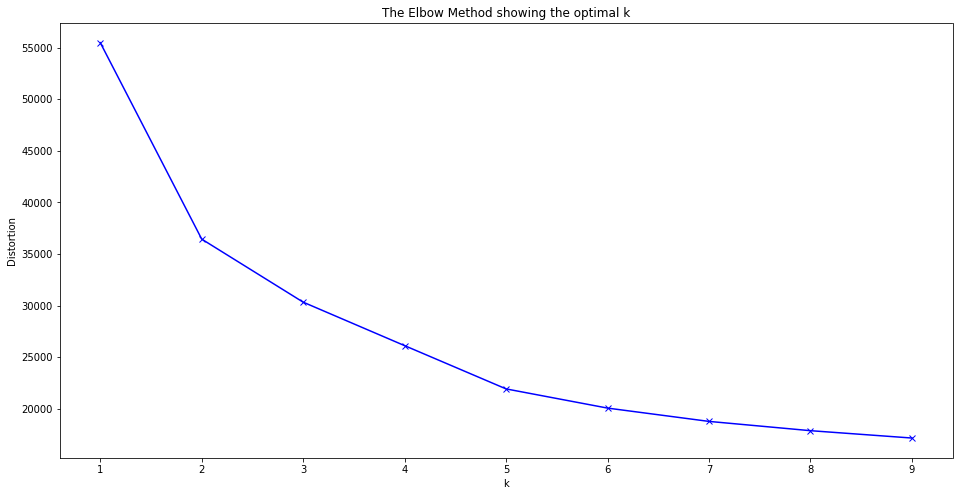

In [14]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Hierarchical Clustering: Dendograms

In [15]:
def linkage_frame(data):
    row_clusters = linkage(data, method='complete', metric='euclidean')
    columns = ['row label 1', 'row label 2', 'distance', 'no. items in clust.']
    index = ['cluster %d' % (i + 1) for i in range(row_clusters.shape[0])]
    linkage_df = pd.DataFrame(row_clusters, columns=columns, index=index)
    return linkage_df

In [17]:
test2 = test1.copy()

In [18]:
linkage_df = linkage_frame(test2.values)
linkage_df.head()

,row label 1,row label 2,distance,no. items in clust.
cluster 1,933.0,1344.0,10.406675,2.0
cluster 2,1144.0,1286.0,10.723805,2.0
cluster 3,244.0,495.0,21.281593,2.0
cluster 4,403.0,1307.0,21.553046,2.0
cluster 5,771.0,1020.0,21.686689,2.0


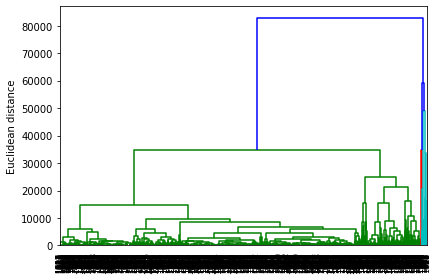

In [19]:
row_dendr = dendrogram(linkage_df, leaf_rotation=90, leaf_font_size=8)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

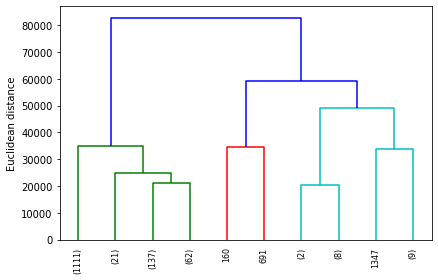

In [20]:
row_dendr = dendrogram(linkage_df, leaf_rotation=90, truncate_mode='lastp', p = 10, leaf_font_size=8)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

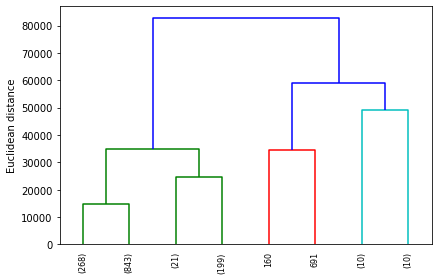

In [21]:
row_dendr = dendrogram(linkage_df, truncate_mode='level', p = 2, leaf_rotation=90, leaf_font_size=8)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

# Random Forest

In [22]:
# Append dataframe of cluster labels to original test dataset 

test_KClass = test.copy()
test_KClass = pd.concat([test_KClass, KClass], axis=1)

In [23]:
# Upsample minority class in test dataset 

minorIndex = test_KClass[test_KClass['KClass']==1].index

resampled = resample(minorIndex, n_samples=1303-50)

resampled_minor = test_KClass.iloc[resampled]

test_data_resampled = pd.concat([test_KClass, resampled_minor], axis=0)

In [25]:
test_data_resampled['KClass'].value_counts()

1    1303
0    1303
Name: KClass, dtype: int64

In [26]:
train['PotentialFraud'].value_counts()

No     4904
Yes     506
Name: PotentialFraud, dtype: int64

In [27]:
train['PotentialFraud'] = train['PotentialFraud']. \
replace({'No':0,'Yes':1})

In [28]:
# Upsample minority class in train dataset 

minorIndex1 = train[train['PotentialFraud']==1].index

resampled1 = resample(minorIndex1, n_samples=4904-506)

resampled_minor1 = train.iloc[resampled1]

train_data_resampled = pd.concat([train, resampled_minor1], axis=0)

In [29]:
train_data_resampled['PotentialFraud'].value_counts()

1    4904
0    4904
Name: PotentialFraud, dtype: int64

In [30]:
# label encode ServiceType features in Test dataset

le = LabelEncoder()
serviceType = le.fit_transform(test_data_resampled['ServiceType'])
test_data_resampled['ServiceType'] = serviceType

In [31]:
# label encode ServiceType features in Train dataset

le1 = LabelEncoder()
serviceType1 = le1.fit_transform(train_data_resampled['ServiceType'])
train_data_resampled['ServiceType'] = serviceType1

In [32]:
# create features and target for train & test datasets for modelling 

features_test = test_data_resampled.drop \
(['Provider', 'KClass'], axis=1)

target_test = test_data_resampled['KClass']

features_train = train_data_resampled.drop \
(['Provider', 'PotentialFraud'], axis=1)

target_train = train_data_resampled['PotentialFraud']

In [33]:
randomForest = ensemble.RandomForestClassifier()

randomForest.fit(features_train, target_train)

print(randomForest.score(features_train, target_train))
print(randomForest.score(features_test, target_test))

0.9996941272430668
0.7240982348426708


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# EDA on New Dataset with K Labels

Text(0, 0.5, 'Unique Group Diag Codes Count')

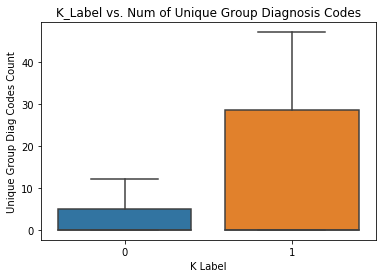

In [34]:
sns.boxplot(x='KClass', y='NumUniqGroupDiagCode', data=test_KClass, \
            showfliers=False).set_title('K_Label vs. Num of Unique Group Diagnosis Codes')
plt.xlabel('K Label')
plt.ylabel('Unique Group Diag Codes Count')

In [42]:
test_KClass.groupby('KClass')['NumUniqGroupDiagCode'].mean()

KClass
0     5.182655
1    38.780000
Name: NumUniqGroupDiagCode, dtype: float64

Text(0, 0.5, 'Unique Claim Admit Diag Codes Count')

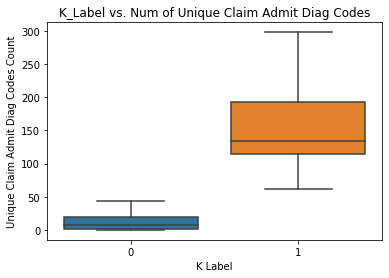

In [35]:
sns.boxplot(x='KClass', y='NumUniqClmAdmitDiagCOde', data=test_KClass, \
            showfliers=False).set_title('K_Label vs. Num of Unique Claim Admit Diag Codes')
plt.xlabel('K Label')
plt.ylabel('Unique Claim Admit Diag Codes Count')

In [41]:
test_KClass.groupby('KClass')['NumUniqClmAdmitDiagCOde'].mean()

KClass
0     14.766692
1    161.180000
Name: NumUniqClmAdmitDiagCOde, dtype: float64

Text(0, 0.5, 'Number of Patients Per Provider')

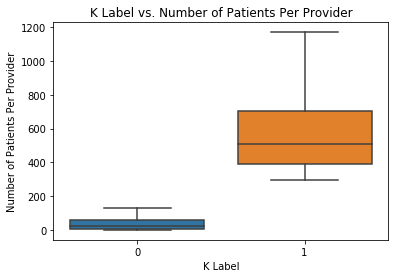

In [36]:
sns.boxplot(x='KClass', y='NumOfPatients', data=test_KClass, \
            showfliers=False).set_title('K Label vs. Number of Patients Per Provider')
plt.xlabel('K Label')
plt.ylabel('Number of Patients Per Provider')

In [40]:
test_KClass.groupby('KClass')['NumOfPatients'].mean()

KClass
0     43.714505
1    605.640000
Name: NumOfPatients, dtype: float64

Text(0, 0.5, 'Number of Doctors Per Provider')

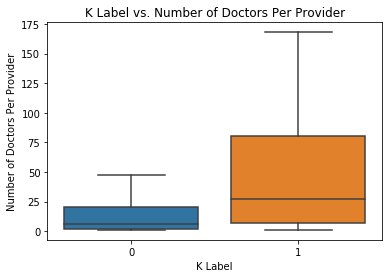

In [37]:
sns.boxplot(x='KClass', y='NumOfDoctors', data=test_KClass, \
            showfliers=False).set_title('K Label vs. Number of Doctors Per Provider')
plt.xlabel('K Label')
plt.ylabel('Number of Doctors Per Provider')

In [39]:
test_KClass.groupby('KClass')['NumOfDoctors'].mean()

KClass
0    14.786646
1    54.280000
Name: NumOfDoctors, dtype: float64